In [1]:
import pandas as pd
import numpy as np

import path
import seaborn as sns
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *

import re


In [2]:
path= Path('../input/nlp-getting-started')
path.ls()

[PosixPath('../input/nlp-getting-started/train.csv'),
 PosixPath('../input/nlp-getting-started/test.csv'),
 PosixPath('../input/nlp-getting-started/sample_submission.csv')]

In [3]:
train=pd.read_csv(path/'train.csv')
test=pd.read_csv(path/'test.csv')
submission=pd.read_csv(path/'sample_submission.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# train = train.drop(columns='id')
# test = test.drop(columns='id')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Distribution of target variable:**

Text(0.5, 1.0, 'Target variable distribution')

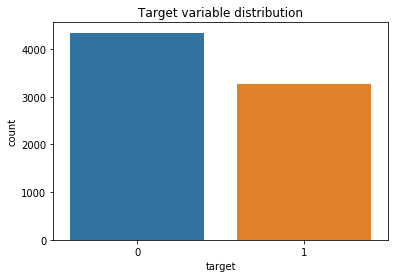

In [5]:
sns.countplot(train.target).set_title('Target variable distribution')

In [6]:
#let's look at the Nan value
(100.0 * train.isna().sum() / train.shape[0]).to_frame(name='percentage').sort_values(by='percentage')

,percentage
id,0.000000
text,0.000000
target,0.000000
keyword,0.801261
location,33.272035


33% percent missing location, 0.8% keyword

In [7]:
#let's see the correlation between keyword and disasters
def is_keyword_in(data):
    if data.keyword in data.text.split():
        return 1
    else:
        return 0
    
train['keyword_appears'] = train[['keyword', 'text']].dropna().apply(is_keyword_in, axis=1)


In [8]:
print('Percentage of keyword appearence in disasters')
100.0 * train[train.target == 1].keyword_appears.value_counts(normalize=True).to_frame(name='percentage')

Percentage of keyword appearence in disasters


,percentage
0.0,58.563023
1.0,41.436977


In [9]:
print('Percentage of keyword appearence in non disasters')
100.0 * train[train.target == 0].keyword_appears.value_counts(normalize=True).to_frame(name='percentage')

Percentage of keyword appearence in non disasters


,percentage
0.0,56.1647
1.0,43.8353


Almost the same numbers of keywords in both situation

Which locations have the most frequent disasters?

In [10]:
train.location.dropna().value_counts().to_frame(name='count')

,count
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"Cuttack, Orissa",1
"Morganville, Texas.",1
Yooooooo,1
"Hartford, Connecticut",1


In [11]:
#Distinct keywords in train dataset
dist_keyword=train['keyword'].value_counts()
dist_keyword

fatalities               45
armageddon               42
deluge                   42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

## **Let's start the Fastai model**

In [12]:
bs=128

In [13]:
#count the null values in each column
train.isnull().sum()

id                    0
keyword              61
location           2533
text                  0
target                0
keyword_appears      61
dtype: int64

In [14]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

we won't delete the location and keyword columns

In [15]:
import copy
train2 =copy.copy(train)

In [16]:
## replacing na values in location,keyword with No
train2['location'].fillna('No',inplace = True)
train2['keyword'].fillna('No',inplace = True) 
# train2.drop(['keyword_appears'], axis=1 ,inplace = True)
test['keyword'].fillna('No',inplace = True) 
test['location'].fillna('No',inplace = True) 

In [17]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_urls(text):
    
    url_pattern = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    return url_pattern


def remove_html(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext
    


train2['text'] = train2['text'].apply(lambda x: remove_urls(x))
train2['text'] = train2['text'].apply(lambda x: remove_html(x))

test['text'] = test['text'].apply(lambda x: remove_urls(x))
test['text'] = test['text'].apply(lambda x: remove_html(x))
        #df[col] = df[col].apply(lambda text: remove_punctuation(text))
#         df[col] = df[col].apply(lambda x: clean_text(x))
     #   df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
      #  df[col] = df[col].apply(lambda x: unslang(x))
train2['text'] = train2['text'].apply(lambda x: remove_emoji(x))
test['text']= test['text'].apply(lambda x: remove_emoji(x))
train2.drop(['keyword_appears'], axis = 1)

,id,keyword,location,text,target
0,1,No,No,Our Deeds are the Reason of this #earthquake M...,1
1,4,No,No,Forest fire near La Ronge Sask. Canada,1
2,5,No,No,All residents asked to 'shelter in place' are ...,1
3,6,No,No,"13,000 people receive #wildfires evacuation or...",1
4,7,No,No,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,No,No,Two giant cranes holding a bridge collapse int...,1
7609,10870,No,No,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,No,No,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1
7611,10872,No,No,Police investigating after an e-bike collided ...,1


In [18]:
# apply tokenization and numericalization
# it basically creates a separate unit (i.e. a “token”) for each separate part of a word
#o get the data ready for a language model
# Language model data
# data_lm = TextLMDataBunch.from_df('.', train_df=train2 , valid_df=test ,text_cols = 'text', bs=48 ).split_by_rand_pct(0.1)

In [19]:
## create databunch with both train and test text and label for language model
bs = 48
data_lm = (TextList.from_df(pd.concat([train[['text']], test[['text']]]), '.')
           .split_by_rand_pct(0.1, seed=42)
           .label_for_lm()
           .databunch(bs=bs, num_workers=1))

In [20]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(5456, 9789)

In [21]:
## check tokenisation looks ok on training set
data_lm.show_batch()

idx,text
0,"from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm on"
1,xxunk game xxbos xxunk xxunk xxmaj people ' annihilated by last nights weather ' ... xxmaj really xxmaj xxunk thought you would have forecast that ... xxbos xxmaj xxunk other xxunk be annihilated xxunk up - to - the - minute feat : xxunk xxbos xxunk xxunk i seen xxmaj xxunk xxmaj xxunk in 2005 when xxmaj rob came back ; xxmaj xxunk as support . xxmaj fucking annihilated the
2,chicago - xxmaj area xxmaj gay xxmaj bar xxmaj admits to xxmaj arson xxmaj scheme : xxmaj frank xxmaj elliott pleaded guilty to hiring an arsonist to to ... http : / / t.co / xxunk xxbos xxmaj trusting xxmaj iran to stop terrorism is like xxunk an arsonist to join the fire brigade - xxmaj telegraph http : / / t.co / xxunk xxbos xxmaj big xxmaj top xxmaj
3,east xxmaj xxunk xxunk building http : / / t.co / xxunk xxbos niggas love hating . xxbos xxunk xxmaj do n't be like that babes <3 you 'll have a ball of fun with me at xxup xxunk ! :) xxbos i liked a @youtube video from xxunk http : / / t.co / xxunk xxmaj minecraft xxmaj xxunk - o xxup blaze xxup que xxup usa xxup hack
4,to be a happy day but it 's a bloody friday xxunk xxrep 4 xxunk xxbos xxunk xxunk i should bloody hope so * she said xxunk her arms sitting back in her chair * xxbos ' i came to kill xxmaj xxunk ... for xxup fun ' : xxmaj video of xxunk and xxunk xxmaj pakistani killer shows him xxunk . http : / / t.co / xxunk xxbos


In [22]:
# List of unique possible tokens is called the vocabulary. Listing below first 20 unique tokens in order of frequency:
# data_lm.vocab.itos[:10]

In [23]:
# we replace the token with word ids
# data_lm.train_ds[0][0].data[:10]

In [24]:
#save and load
# data_lm.save('tmp_lm')
# data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=48)

In [25]:
#dwnld wiki103t to train model weight
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


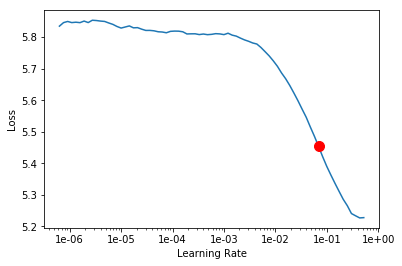

In [26]:
learn.lr_find()
#train last layer
learn.recorder.plot(skip_end=15 ,suggestion=True)

In [27]:
# access the corresponding learning rate 
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.06918309709189363

In [28]:
lr = 1e-2
lr *= bs/48

In [29]:
# just fine-tuning the last layers
learn.fit_one_cycle(4, lr ,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.851868,3.762139,0.355283,00:05
1,3.978094,3.399087,0.399814,00:05
2,3.565922,3.301796,0.412091,00:05
3,3.365664,3.284777,0.414881,00:05


In [30]:
learn.unfreeze()
learn.fit_one_cycle(10, lr/8, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.189915,3.204182,0.423847,00:07
1,3.086931,3.145515,0.432143,00:07
2,2.957583,3.068869,0.446019,00:07
3,2.812179,3.028883,0.454836,00:07
4,2.668868,3.026144,0.455171,00:07
5,2.526497,3.014939,0.461123,00:07
6,2.393943,3.017669,0.462798,00:07
7,2.295583,3.028005,0.465737,00:07
8,2.229485,3.034883,0.465476,00:07
9,2.187034,3.038361,0.464993,00:07


In [31]:
## save model and encoder
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [32]:
data_clas = (TextList.from_df(train[['text', 'target']], '.', vocab=data_lm.vocab)
#           .split_by_folder(valid='test')
             .split_by_rand_pct(0.1)
             .label_from_df('target')
             .add_test(TextList.from_df(test[['text']], '.', vocab=data_lm.vocab))
#              .filter_missing_y()
             .databunch(bs=bs, num_workers=1))
data_clas.save('tmp_clas')

In [33]:
data_clas.show_batch()


text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup xxunk xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n \n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,1
xxbos xxmaj no # news of # hostages in # xxmaj libya \n \n http : / / t.co / xxunk \n \n # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1


**Text classifier learner **

In [34]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('fine_tuned_enc')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-02


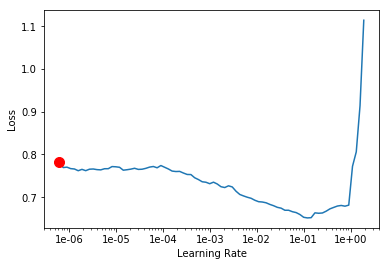

In [35]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [36]:
lr=2e-2
lr *= bs/48

In [37]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.523350,0.483231,0.760841,00:03


In [38]:
learn.save('first')
learn.load('first')
learn.freeze_to(-2)

In [39]:
learn.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.517741,0.466405,0.787122,00:03
1,0.462745,0.440266,0.785808,00:03
2,0.411852,0.449109,0.793693,00:04


In [40]:
learn.save('second')
learn.load('second');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.411695,0.435463,0.814717,00:05


In [41]:
learn.save('third')
learn.load('third');
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.328826,0.498895,0.780552,00:06
1,0.271888,0.493785,0.806833,00:07


In [42]:
result = pd.DataFrame()
for i,row in test.iterrows():
    result.loc[i,"target"] = learn.predict(row["text"])[0]

In [43]:
## get test set predictions and ids
# preds, _ = learn.get_preds(ds_type=DatasetType.Test,  ordered=True)
# preds = preds.argmax(dim=-1)

result["id"] = test.id

In [44]:
result[["id","target"]].to_csv("submission.csv",index=False)
result.head()

,target,id
0,1,0
1,1,2
2,1,3
3,1,9
4,1,11
